# プロビット回帰モデル

**プロビット回帰モデル**（probit regression model）は、二値の目的変数に対するGLMであり、リンク関数として標準正規分布の逆累積分布関数（プロビット関数）を用いる。ロジスティック回帰と同じ変量成分（ベルヌーイ分布）を持つが、リンク関数が異なる。計量経済学では潜在変数モデルとの対応から好んで使われるが、ここではGLMの枠組みから定式化する。

## GLMとしての定式化

### 変量成分

目的変数 $Y_i$ は「成功」（1）か「失敗」（0）の二値をとり、成功確率 $\pi_i$ のベルヌーイ分布に従う：

$$
Y_i \sim \text{Bernoulli}(\pi_i), \quad i = 1, \dots, n
$$

これはロジスティック回帰と全く同じである。

### リンク関数

プロビット回帰では、**プロビットリンク**（probit link）を用いる：

$$
g(\pi_i) = \Phi^{-1}(\pi_i)
$$

ここで $\Phi$ は標準正規分布の累積分布関数（CDF）であり、$\Phi^{-1}$ はその逆関数である。

ロジットリンクが正準リンク（canonical link）であるのに対し、プロビットリンクは非正準リンクである。この違いはIRLSの重みに影響する。

### 系統的成分

線形予測子 $\eta_i$ は

$$
\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta} = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip}
$$

### 3つをまとめると

$$
\Phi^{-1}(\pi_i) = \mathbf{x}_i^\top \boldsymbol{\beta}
$$

逆リンク関数で $\pi_i$ を表すと

$$
\pi_i = \Phi(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

すなわち、線形予測子を標準正規分布のCDFで変換したものが成功確率となる。

## プロビット関数とロジスティック関数の比較

計算量が大きいプロビット回帰の代用として、リンク関数をシグモイド・ロジスティック関数に置き換えたロジスティック回帰が使われることが多かった。両者はかなり似ている。（なおロジスティック関数への入力値を1.7倍すると更に近似精度はあがる）

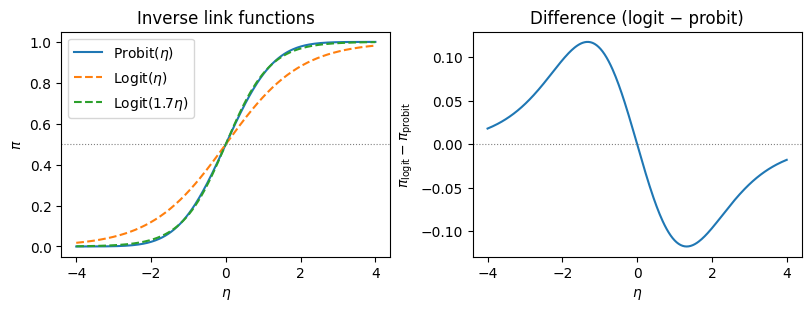

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

eta = np.linspace(-4, 4, 300)
logistic_curve = 1 / (1 + np.exp(-eta))
logistic_curve_17 = 1 / (1 + np.exp(-1.7 * eta))
probit_curve = stats.norm.cdf(eta)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

# 左: 逆リンク関数の比較
axes[0].plot(eta, probit_curve, label=r"Probit($\eta$)")
axes[0].plot(eta, logistic_curve, label=r"Logit($\eta$)", linestyle="--")
axes[0].plot(eta, logistic_curve_17, label=r"Logit($1.7\eta$)", linestyle="--")
axes[0].axhline(0.5, color="gray", linestyle=":", linewidth=0.8)
axes[0].set(xlabel=r"$\eta$", ylabel=r"$\pi$",
            title="Inverse link functions")
axes[0].legend()

# 右: 差の拡大
axes[1].plot(eta, logistic_curve - probit_curve)
axes[1].axhline(0, color="gray", linestyle=":", linewidth=0.8)
axes[1].set(xlabel=r"$\eta$", ylabel=r"$\pi_{\mathrm{logit}} - \pi_{\mathrm{probit}}$",
            title="Difference (logit \u2212 probit)")

plt.show()

中心付近では両者はほぼ一致する。ロジスティック分布は正規分布よりも裾が厚いため、$|\eta|$ が大きい領域ではロジスティック関数の方がゆっくりと0・1に近づく。

## 係数の解釈：限界効果

ロジスティック回帰の係数はオッズ比として直感的に解釈できるが、プロビット回帰にはオッズ比に相当する解釈がない。代わりに**限界効果**（marginal effects）で解釈する。

### 限界効果の導出

$\pi_i = \Phi(\mathbf{x}_i^\top \boldsymbol{\beta})$ を $x_j$ で偏微分すると

$$
\frac{\partial \pi_i}{\partial x_j} = \phi(\mathbf{x}_i^\top \boldsymbol{\beta})\, \beta_j
$$

ここで $\phi(\cdot)$ は標準正規分布の確率密度関数（PDF）である。

限界効果は $\mathbf{x}_i$ の値に依存する。これはプロビット回帰（およびロジスティック回帰）の非線形性による。実務では以下の方法で要約する：

- **平均での限界効果**（Marginal Effects at the Mean: MEM）: $\mathbf{x}_i = \bar{\mathbf{x}}$ での限界効果
- **平均限界効果**（Average Marginal Effects: AME）: 全観測の限界効果の平均 $\frac{1}{n} \sum_{i=1}^n \phi(\mathbf{x}_i^\top \hat{\boldsymbol{\beta}})\, \hat{\beta}_j$

AMEの方が推奨されることが多い。

## 最尤推定

### 対数尤度関数

$n$ 個の独立な観測 $(y_i, \mathbf{x}_i)$ に対する対数尤度は

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i \log \Phi(\eta_i) + (1 - y_i) \log(1 - \Phi(\eta_i)) \right]
$$

ここで $\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}$ である。

### スコア関数

$\frac{\partial}{\partial \boldsymbol{\beta}} \Phi(\eta_i) = \phi(\eta_i)\, \mathbf{x}_i$ を用いると

$$
\frac{\partial \ell}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} \frac{(y_i - \pi_i)\, \phi(\eta_i)}{\pi_i(1 - \pi_i)}\, \mathbf{x}_i
$$

ここで $\pi_i = \Phi(\eta_i)$ である。ロジスティック回帰のスコア関数 $\sum_i (y_i - \pi_i) \mathbf{x}_i$ と比較すると、$\phi(\eta_i) / [\pi_i(1-\pi_i)]$ の重みが追加されている。これは非正準リンクを用いていることに起因する。

### Fisher情報行列

$$
\mathbf{F}(\boldsymbol{\beta}) = \mathbf{X}^\top \mathbf{W} \mathbf{X}
$$

ここで重み行列 $\mathbf{W} = \text{diag}(w_1, \dots, w_n)$ の要素は

$$
w_i = \frac{\phi(\eta_i)^2}{\Phi(\eta_i)(1 - \Phi(\eta_i))}
$$

これがロジスティック回帰の $w_i = \pi_i(1-\pi_i)$ と異なる点であり、プロビット回帰のIRLSにおける重要な違いである。

### IRLS

更新式はGLM一般と同じ形をとる：

$$
\boldsymbol{\beta}^{(t+1)} = (\mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{X})^{-1}\, \mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{z}^{(t)}
$$

作業従属変数は

$$
z_i^{(t)} = \eta_i^{(t)} + \frac{y_i - \pi_i^{(t)}}{\phi(\eta_i^{(t)})} \cdot \frac{\pi_i^{(t)}(1 - \pi_i^{(t)})}{\phi(\eta_i^{(t)})}
$$

ここでリンク関数の微分 $g'(\pi) = 1 / \phi(\Phi^{-1}(\pi))$ が反映されている。整理すると

$$
z_i^{(t)} = \eta_i^{(t)} + \frac{y_i - \Phi(\eta_i^{(t)})}{\phi(\eta_i^{(t)})}
$$

### IRLSのスクラッチ実装

In [20]:
def probit_regression_irls(
    X: np.ndarray,
    y: np.ndarray,
    max_iter: int = 25,
    tol: float = 1e-8,
) -> dict:
    """
    IRLSによるプロビット回帰の最尤推定

    Parameters
    ----------
    X : np.ndarray, shape (n, p)
        計画行列（切片列を含む）
    y : np.ndarray, shape (n,)
        目的変数（0/1）
    max_iter : int
        最大反復回数
    tol : float
        収束判定の閾値

    Returns
    -------
    dict
        beta, se, log_likelihood, n_iter
    """
    n, p = X.shape
    beta = np.zeros(p)

    for iteration in range(max_iter):
        eta = X @ beta
        pi = stats.norm.cdf(eta)
        phi = stats.norm.pdf(eta)

        # 数値安定性のためクリップ
        pi = np.clip(pi, 1e-10, 1 - 1e-10)
        phi = np.clip(phi, 1e-10, None)

        # 重み: w_i = phi(eta_i)^2 / [pi_i * (1 - pi_i)]
        w = phi**2 / (pi * (1 - pi))

        # 作業従属変数: z_i = eta_i + (y_i - pi_i) / phi(eta_i)
        z = eta + (y - pi) / phi

        # 重み付き最小二乗法
        W = np.diag(w)
        XtWX = X.T @ W @ X
        XtWz = X.T @ W @ z

        beta_new = np.linalg.solve(XtWX, XtWz)

        # 収束判定
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    # 最終結果
    eta = X @ beta
    pi = stats.norm.cdf(eta)
    pi = np.clip(pi, 1e-15, 1 - 1e-15)
    log_lik = np.sum(y * np.log(pi) + (1 - y) * np.log(1 - pi))

    # 標準誤差
    phi = stats.norm.pdf(eta)
    w = phi**2 / (pi * (1 - pi))
    XtWX = X.T @ np.diag(w) @ X
    cov = np.linalg.inv(XtWX)
    se = np.sqrt(np.diag(cov))

    return {
        "beta": beta,
        "se": se,
        "log_likelihood": log_lik,
        "n_iter": iteration + 1,
        "cov": cov,
    }

### シミュレーションデータでの検証

スクラッチ実装を `statsmodels` の結果と比較する。

In [3]:
import pandas as pd
import statsmodels.api as sm

# データ生成（プロビットモデルから）
rng = np.random.default_rng(42)
n = 500
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
beta_true = np.array([-0.3, 0.7, -0.5])  # beta_0, beta_1, beta_2
X = np.column_stack([np.ones(n), x1, x2])
eta = X @ beta_true
pi_true = stats.norm.cdf(eta)
y = rng.binomial(1, pi_true)

print(f"サンプルサイズ: {n}")
print(f"真の係数: \u03b2\u2080={beta_true[0]}, \u03b2\u2081={beta_true[1]}, \u03b2\u2082={beta_true[2]}")
print(f"y=1 の割合: {y.mean():.3f}")

サンプルサイズ: 500
真の係数: β₀=-0.3, β₁=0.7, β₂=-0.5
y=1 の割合: 0.426


In [4]:
# スクラッチ実装
result_irls = probit_regression_irls(X, y)

# statsmodels
model_sm = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.Probit()))
result_sm = model_sm.fit()

# 比較
comparison = pd.DataFrame({
    "真の値": beta_true,
    "IRLS (自前)": result_irls["beta"],
    "statsmodels": result_sm.params,
    "SE (自前)": result_irls["se"],
    "SE (statsmodels)": result_sm.bse,
}, index=["\u03b2\u2080", "\u03b2\u2081", "\u03b2\u2082"])

print(f"IRLS 反復回数: {result_irls['n_iter']}")
print(f"対数尤度 (自前): {result_irls['log_likelihood']:.4f}")
print(f"対数尤度 (statsmodels): {result_sm.llf:.4f}")
print()
comparison

IRLS 反復回数: 7
対数尤度 (自前): -261.5751
対数尤度 (statsmodels): -261.5751



,真の値,IRLS (自前),statsmodels,SE (自前),SE (statsmodels)
β₀,-0.3,-0.257793,-0.257793,0.063961,0.063961
β₁,0.7,0.708134,0.708134,0.077118,0.077118
β₂,-0.5,-0.542766,-0.542766,0.070082,0.070082


## 限界効果の計算

In [5]:
beta_hat = result_sm.params

# 平均限界効果（AME）
eta_hat = X @ beta_hat
phi_hat = stats.norm.pdf(eta_hat)
ame = phi_hat.mean() * beta_hat[1:]  # 切片を除く

# 平均での限界効果（MEM）
x_mean = X.mean(axis=0)
eta_mean = x_mean @ beta_hat
phi_mean = stats.norm.pdf(eta_mean)
mem = phi_mean * beta_hat[1:]

me_df = pd.DataFrame({
    "\u03b2": beta_hat[1:],
    "AME": ame,
    "MEM": mem,
}, index=["x\u2081", "x\u2082"])

print("限界効果の比較")
print(f"  \u03c6(X\u03b2 の平均): {phi_hat.mean():.4f}")
print(f"  \u03c6(X\u0304\u03b2):       {phi_mean:.4f}")
print()
me_df

限界効果の比較
  φ(Xβ の平均): 0.2960
  φ(X̄β):       0.3874



,β,AME,MEM
x₁,0.708134,0.209580,0.274296
x₂,-0.542766,-0.160637,-0.210240


## 実データでの例

Titanic データセットを用いて、ロジスティック回帰と同じデータでプロビット回帰を行い結果を比較する。

In [6]:
from statsmodels.formula.api import probit, logit

# statsmodels 組み込みの Titanic データ
titanic = sm.datasets.get_rdataset("Titanic", "datasets").data

# 集計データを個票データに展開
rows = []
for _, row in titanic.iterrows():
    for _ in range(int(row["Freq"])):
        rows.append({
            "Class": row["Class"],
            "Sex": row["Sex"],
            "Age": row["Age"],
            "Survived": 1 if row["Survived"] == "Yes" else 0,
        })
df = pd.DataFrame(rows)
print(f"サンプルサイズ: {len(df)}")
print(f"生存率: {df['Survived'].mean():.3f}")

サンプルサイズ: 2201
生存率: 0.323


In [7]:
# プロビット回帰
model_probit = probit("Survived ~ C(Class) + C(Sex) + C(Age)", data=df).fit(disp=0)
print(model_probit.summary())

                          Probit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 2201
Model:                         Probit   Df Residuals:                     2195
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                  0.2011
Time:                        19:08:11   Log-Likelihood:                -1106.3
converged:                       True   LL-Null:                       -1384.7
Covariance Type:            nonrobust   LLR p-value:                4.286e-118
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2366      0.098     12.565      0.000       1.044       1.429
C(Class)[T.2nd]     -0.6297      0.118     -5.335      0.000      -0.861      -0.398
C(Class)[T.3rd]     -1.0274 

In [8]:
# ロジスティック回帰との係数比較
model_logit = logit("Survived ~ C(Class) + C(Sex) + C(Age)", data=df).fit(disp=0)

coef_comparison = pd.DataFrame({
    "Probit \u03b2": model_probit.params,
    "Logit \u03b2": model_logit.params,
    "Probit/Logit": model_probit.params / model_logit.params,
})

print(f"Probit/Logit 比の平均: {(model_probit.params / model_logit.params).mean():.3f}")
print(f"理論的近似値:          0.600")
print()
coef_comparison

Probit/Logit 比の平均: 0.596
理論的近似値:          0.600



,Probit β,Logit β,Probit/Logit
Intercept,1.236591,2.043837,0.605034
C(Class)[T.2nd],-0.629726,-1.018095,0.618534
C(Class)[T.3rd],-1.027435,-1.777762,0.577937
C(Class)[T.Crew],-0.539910,-0.857676,0.629503
C(Sex)[T.Male],-1.449730,-2.420060,0.599047
C(Age)[T.Child],0.580338,1.061542,0.546693


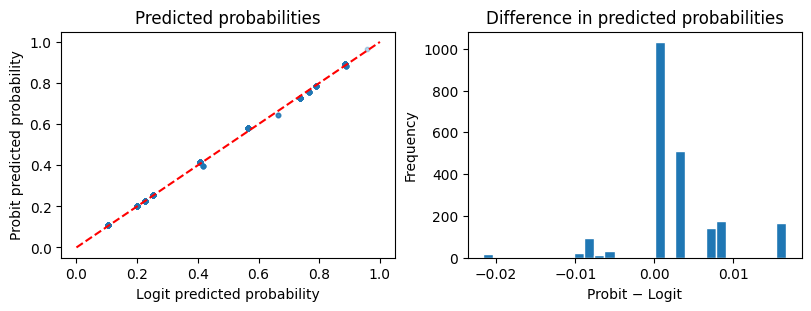

In [9]:
# 予測確率の比較
pred_probit = model_probit.predict(df)
pred_logit = model_logit.predict(df)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

axes[0].scatter(pred_logit, pred_probit, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], "r--")
axes[0].set(xlabel="Logit predicted probability",
            ylabel="Probit predicted probability",
            title="Predicted probabilities")

axes[1].hist(pred_probit - pred_logit, bins=30, edgecolor="white")
axes[1].set(xlabel="Probit \u2212 Logit", ylabel="Frequency",
            title="Difference in predicted probabilities")

plt.show()

In [10]:
# 限界効果（AME）
# formula APIで推定したモデルから計画行列を取得
from statsmodels.discrete.discrete_model import Probit

margeff = model_probit.get_margeff(at="overall")
print(margeff.summary())

       Probit Marginal Effects       
Dep. Variable:               Survived
Method:                          dydx
At:                           overall
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
C(Class)[T.2nd]     -0.1780      0.033     -5.435      0.000      -0.242      -0.114
C(Class)[T.3rd]     -0.2904      0.026    -11.054      0.000      -0.342      -0.239
C(Class)[T.Crew]    -0.1526      0.026     -5.802      0.000      -0.204      -0.101
C(Sex)[T.Male]      -0.4097      0.018    -23.050      0.000      -0.445      -0.375
C(Age)[T.Child]      0.1640      0.039      4.246      0.000       0.088       0.240


## ロジスティック回帰との比較まとめ

### 係数の近似関係

ロジスティック分布の分散は $\pi^2/3 \approx 3.29$ であり、標準正規分布の分散は1である。したがって、プロビットとロジットの係数には近似的に以下の関係が成り立つ：

$$
\beta_{\text{probit}} \approx \frac{\pi}{\sqrt{3}} \cdot \frac{1}{\pi / \sqrt{3}} \cdot \beta_{\text{probit}} \quad \Longleftrightarrow \quad \beta_{\text{probit}} \approx \frac{1}{1.6} \beta_{\text{logit}} \approx 0.625\, \beta_{\text{logit}}
$$

実務では $\beta_{\text{probit}} \approx 0.6 \times \beta_{\text{logit}}$ として知られる。

### 裾の厚さの違い

ロジスティック分布は正規分布よりも裾が厚い。そのため：

- $\pi$ が0や1に近い領域では両モデルの予測確率に差が生じうる
- 中心付近（$\pi \approx 0.5$）ではほとんど違いがない
- 実用上、二値応答データへの当てはめではロジットとプロビットの結果はほとんど区別がつかないことが多い

### 選択の指針

| 観点 | ロジスティック回帰 | プロビット回帰 |
|------|:---:|:---:|
| リンク関数 | ロジット（正準リンク） | プロビット（非正準リンク） |
| 係数の解釈 | オッズ比 $\exp(\beta)$ | 限界効果 $\phi(\mathbf{x}^\top\boldsymbol{\beta}) \beta_j$ |
| 主な使用分野 | 医学・疫学・機械学習 | 計量経済学 |
| 潜在変数解釈 | ロジスティック分布の誤差項 | 正規分布の誤差項 |
| 計算 | 正準リンクのためIRLSが安定 | 非正準リンクのためやや不安定 |

## 参考文献

:::{card}

McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall.

GLMの原典。プロビットリンクを含む各種リンク関数の理論

:::

:::{card}

Agresti, A. (2013). *Categorical Data Analysis* (3rd ed.). Wiley.

カテゴリカルデータ分析の標準的教科書。ロジットとプロビットの比較が詳しい

:::

:::{card}

Cameron, A. C., & Trivedi, P. K. (2005). *Microeconometrics: Methods and Applications*. Cambridge University Press.

計量経済学の観点からプロビットモデルと限界効果を詳説

:::